In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


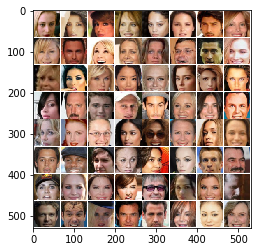

torch.Size([64, 3, 64, 64])


In [4]:
### LOAD DATA ###

loaders, imsize = load(name='CelebA64', path='/home/shared/phase-retrieval/data/CelebA64.h5', batch_size=64)
trainloader = loaders['train']
valloader = loaders['val']

sample = next(iter(loaders['train']))
plot_grid(sample, figsize=(4, 4))
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
# Function to compute test images

def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        ft = torch.rfft(data, 2, onesided=False)
        magn = torch.sqrt(torch.sum(ft**2, -1))
        ouput = model(magn)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [6]:
# Define Gen and Disc loss

#def gen_loss(disc_output_generated, gen_output, x):
#    reconstruction = torch.mean(torch.abs(x-gen_output))
#    adversarial = 0.5*torch.mean((1-disc_output_generated)**2)
#    return reconstruction + adversarial

def gen_loss(disc_gen, gen_output, x, lmd):
    reconstruction = torch.mean(torch.abs(x - gen_output))
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial + lmd * reconstruction

#def disc_loss(disc_output_real, disc_output_generated):
#    loss_real = 0.5*torch.mean((1-disc_output_real)**2)
#    loss_generated = 0.5*torch.mean((disc_output_generated)**2)
#    return loss_real+loss_generated

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [7]:
#CNN Image network with FC layers in between

class DropModule(nn.Module):
    
    def __init__(self, p=0.0):
        super().__init__()
        self.p = p
        self.drop = True

    def forward(self, x):
        return nn.functional.dropout(x, p=self.p, training=self.drop)

class KernModule(nn.Module):
    
    def __init__(self, h, p):
        super(KernModule, self).__init__()
        self.h = h
        self.layers = nn.Sequential(
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            DropModule(p=p),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            DropModule(p=p),
            nn.ReLU(),
        )
        
    def forward(self, x):
        shp = x.shape
        return self.layers(x.view(shp[0], self.h)).view(*shp)

class ConvNet(nn.Module):

    __constants__ = ['mean', 'std']

    def __init__(self, imsize=(1, 28, 28), p=0.0, outsize=None, s=32, mean=None, std=None):
        super(ConvNet, self).__init__()
        print("Version 0.6")
        pow_pad = (2 ** (int(np.ceil(np.log2(imsize[-2])))) - imsize[-2],
                   2 ** (int(np.ceil(np.log2(imsize[-1])))) - imsize[-1])
        kern_size = 4 * ((imsize[1] + pow_pad[0]) // 16) * ((imsize[2] + pow_pad[1]) // 16) * s
        print("Additional padding to fit 2 exp:", pow_pad)
        print("Kern size:", kern_size)
        self.imsize = imsize
        self.p = p
        if outsize is None:
            self.outsize = imsize
        else:
            self.outsize = outsize
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(imsize))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(imsize))
        else:
            self.register_buffer('std', torch.Tensor(std))
            
        self.layers = nn.Sequential(
            nn.Conv2d(imsize[0], imsize[0], kernel_size=1, padding=pow_pad), #32x32x1 = 1024
            nn.BatchNorm2d(imsize[0]),
            DropModule(p=self.p),
            nn.ReLU(),
            nn.Conv2d(imsize[0], 1*s, kernel_size=5, padding=2), #32x32x32 = 32768
            nn.BatchNorm2d(1*s),
            DropModule(p=self.p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #16x16x32 = 8192
            nn.Conv2d(1*s, 2*s, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*s),
            DropModule(p=self.p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8x64 = 4096
            nn.Conv2d(2*s, 4*s, kernel_size=3, padding=1),
            nn.BatchNorm2d(4*s),
            DropModule(p=self.p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4x128 = 2048
            nn.Conv2d(4*s, 4*s, kernel_size=3, padding=1),
            nn.BatchNorm2d(4*s),
            DropModule(p=self.p),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 2x2x128 = 512
            KernModule(h=kern_size, p=self.p),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(4*s, 4*s, kernel_size=3, padding=1),
            nn.BatchNorm2d(4*s),
            DropModule(p=self.p),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(4*s, 2*s, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*s),
            DropModule(p=self.p),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(2*s, 1*s, kernel_size=3, padding=1),
            nn.BatchNorm2d(1*s),
            DropModule(p=self.p),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(1*s, self.outsize[0], kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        N = x.shape[0]
        x_norm = (x - self.mean) / self.std
        out = self.layers(x_norm)[..., :self.outsize[-2], :self.outsize[-1]]
        return out
    
    def drop(self, drop):
        for m in self.modules():
            if isinstance(m, DropModule):
                m.drop = drop

In [9]:
### Create new models ###

gen = ConvNet(imsize=(3, 64, 64), outsize=imsize, s=64, p=0.1)
disc = models.ConvDiscriminator(imsize=(6, 64, 64), s=64)

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [10]:
# Set training parameters

history = []
g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)
lmd = 1e3 # loss signal

In [11]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

gen_out = gen(sample_magnitudes)

xm = torch.cat([sample, sample_magnitudes], dim=1)
disc_output_real = disc(xm)
disc_output_generated = disc(torch.cat([gen_out, sample_magnitudes], dim=1))

g_loss = gen_loss(disc_output_generated, gen_out, sample, lmd)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 268.4607238769531
Discriminator initial loss: 0.6953116059303284


/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [12]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        
        with tqdm_notebook(total=len(loader_train.dataset)) as progress_bar:
            for t, x in enumerate(loader_train):
                # move x to device and reduce to magnitude information in fourier space
                x = x.to(device=device)
                ft =  torch.rfft(x, 2, onesided=False)
                magnitudes = torch.sqrt(torch.sum(ft**2, -1))

                # calc gen output
                gen.train()
                gen_output = gen(magnitudes)

                # calc disc output for real and generated image
                xm = torch.cat([x, magnitudes], dim=1)
                disc.train()
                disc_output_real = disc(xm)
                disc_output_generated = disc(torch.cat([gen_output, magnitudes], dim=1))

                # calculate generator loss and update generator
                g_loss = gen_loss(disc_output_generated, gen(magnitudes), x, lmd)
                history_g.append(g_loss.item())
                g_opt.zero_grad()
                g_loss.backward(retain_graph=True)
                g_opt.step()

                # calculate discriminator loss and update discriminator
                d_loss = disc_loss(disc_output_real, disc_output_generated)
                history_d.append(d_loss.item())
                d_opt.zero_grad()
                d_loss.backward()
                d_opt.step()

                mse_loss = torch.mean((x - gen_output) ** 2)
                history_mse.append(mse_loss.detach().cpu().item())

                progress_bar.set_postfix(g_loss=np.mean(history_g[-100:]),
                                         d_loss=np.mean(history_d[-100:]),
                                         mse=np.mean(history_mse[-100:]))
                progress_bar.update(x.size(0))
            
        plt.plot(history_g[-10000:], label="Gen loss")
        plt.plot(history_d[-10000:], label="Disc loss")
        plt.plot(history_mse[-10000:], label="MSE")
        plt.legend()
        plt.show()
        
        test_images, test_outputs = test_generator(gen, device, valloader)
        plot_grid(np.vstack([test_images[:16],test_outputs[:16], test_images[16:32], test_outputs[16:32]]), figsize=(8,8))
        
        mse_val = np.mean((test_outputs - test_images)**2)
        print("Mean squared dist:", mse_val)
        
        gen_weights = gen.state_dict().copy()
        disc_weights = disc.state_dict().copy()
        torch.save(gen_weights, "../cache/Generator64CelebADrop10_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        torch.save(disc_weights, "../cache/Discriminator64CelebADrop10_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        #if mse_val < 0.012:
        #    break
        
    return history

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


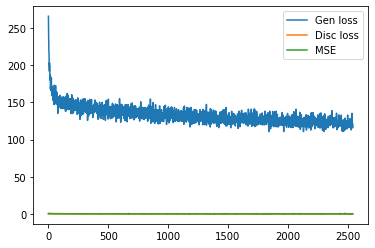

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


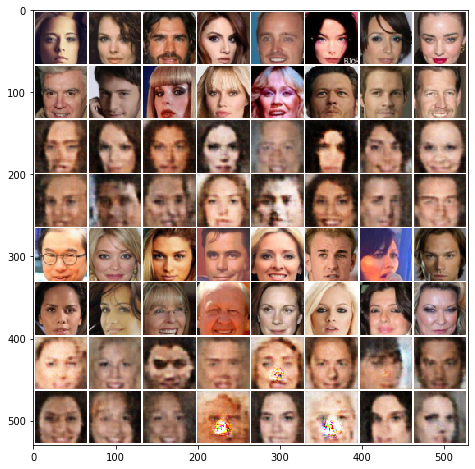

Mean squared dist: 0.02771186


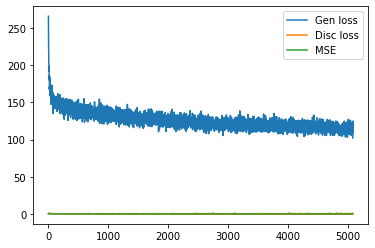

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


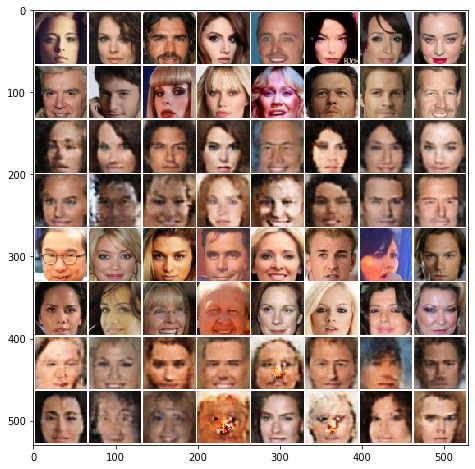

Mean squared dist: 0.024568703


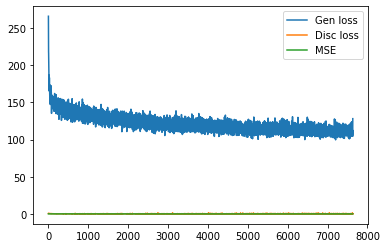

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


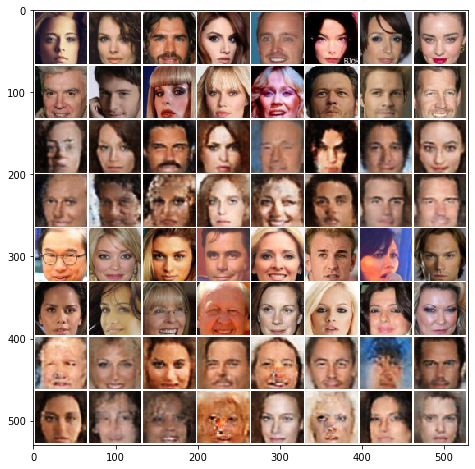

Mean squared dist: 0.023525698


In [ ]:
### TRAIN MODEL ###

import time
num_epochs = 100

train_model(gen, disc, g_opt, d_opt, device, trainloader, epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/cGAN/Generator64CelebA1e3Drop10_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))
torch.save(disc_weights, "../cache/cGAN/Discriminator64CelebA1e3Drop10_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))

In [25]:
### LOAD MODEL ####

gen = ConvNet(imsize=(3, 64, 64), outsize=imsize, s=64, p=0.05)
disc = models.ConvDiscriminator(imsize=(6, 64, 64), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/Generator64CelebADrop05_0073_20191010_043158_0.017.sd", map_location={'cuda:1': device.__str__()}));
#disc.load_state_dict(torch.load("../cache/models/cGAN_CelebA_no_z/Discriminator64CelebA_0080_20190921_011857_0.015.sd", map_location={'cuda:1': device.__str__()}));

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [26]:
# Calculate test predictions #

test_images, test_outputs = test_generator(gen, device, loaders['test'])
print(test_images.shape)

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(19963, 3, 64, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


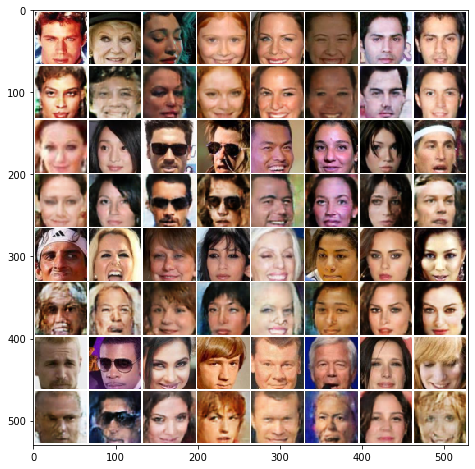

In [27]:
# Plot test predictions #

to_plot = np.stack([test_images[:32].reshape(4, 8*3, 64, 64), 
                    test_outputs[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(torch.Tensor(to_plot), figsize=(8,8), file="../out/cgan/celeba/ConvGenerator64CelebA_Drop05.png")

In [28]:
# Benchmark test predictions #

benchmark(pred=test_outputs[:1024], true=test_images[:1024], check=["mse", "mae", "ssim", "magn", "imcon"])

Signal error:
  MSE: 0.017183479111963607, std: 0.015439697413109568
  MAE: 0.08974393975586281, std: 0.033005504604196136
  SSIM: 0.6532603175701805, std: 0.12002299892134621

Magnitude error:
  MSE Magnitude: 22.269897554119048, std: 16.02652872866847

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01718 | 0.08974 | 0.6533 | 22.27 |


## Evaluation for different cGAN models (random z and 1024 samples)

| Nr | Type | Loss | Dropout Train (Test) | Size | epochs | MSE | MAE | SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Conv | log GAN + 1e3 * MAE | 0.5 (0.5) | 64 | 100 | 0.03057 | 0.1248 | 0.5304 | 45.48 |
| 1 | Conv | log GAN + 1e3 * MAE | 0.5 (0.0) | 64 | 100 | 0.1555 | 0.3233 | 0.2841 | 609.9 |
| 2 | Conv | log GAN + 1e3 * MAE | 0.2 (0.2) | 64 | 100 | 0.02102 | 0.1005 | 0.6084 | 28.10 |
| 3 | Conv | log GAN + 1e3 * MAE | 0.1 (0.1) | 64 | 100 | 0.01754 | 0.09152 | 0.6360 | 21.89 |
| 4 | Conv | log GAN + 1e3 * MAE | 0.05 (0.05) | 64 | 74 | 0.01693 | 0.08926 | 0.6537 | 22.03 |
| 4 | Conv | log GAN + 1e3 * MAE | 0.05 (0.0) | 64 | 74 | 0.02174 | 0.1130 | 0.6699 | 52.26 |




## Test
---

In [29]:
gen.layers

Sequential(
  (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): DropModule()
  (3): ReLU()
  (4): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): DropModule()
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): DropModule()
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): DropModule()
  (17): ReLU()
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [32]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft**2, -1) + 1e-16)
    return mags

In [33]:
### Latent optimization over Kernel layers ###

import copy

def genopt2(sample_magnitudes, gen, device, max_steps=5000, max_loss=0.0, lr=1.0, progress_bar=None):
       
    total_losses = np.full((len(sample_magnitudes), max_steps + 1), np.NAN)
    total_out = []

    with tqdm_notebook(total=len(sample_magnitudes)) as progress_bar:
        for i, magn in enumerate(sample_magnitudes):
            magn.unsqueeze_(0)

            cur_model = copy.deepcopy(gen)
            cur_model.to(device)
            cur_model.eval()
            optimizer = optim.Adam(cur_model.layers[24].parameters(), lr=lr)

            last_out = cur_model(magn)
            pred_magn = calc_mags(last_out)
            loss = torch.mean((pred_magn - magn) ** 2)

            losses = [loss.item()]
            best_out = last_out
            best_loss = np.Inf

            for j in range(max_steps):

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                last_out = cur_model(magn)
                pred_magn = calc_mags(last_out)
                loss = torch.mean((pred_magn - magn) ** 2)

                losses.append(loss.item())
                if loss < best_loss:
                    best_loss = loss
                    best_out = last_out.detach().cpu().numpy()
                if loss < max_loss:
                    break
                    
                progress_bar.set_postfix(cur_loss=np.mean(losses[-100:]),
                                         iteration=j + 1)
                
            total_losses[i, :(j+2)] = losses
            total_out.append(best_out)

            progress_bar.update(1)
        
    return np.vstack(total_out), total_losses

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))



Batch 1/1 finished
[10.77982521  4.30909348  4.26821518  3.04966116]


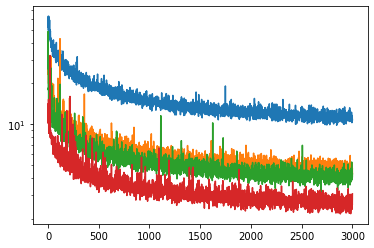

In [34]:
### Latent z optimization ###

num_batches = 1
batch_size = 4
max_steps = 3000
max_loss = 0.0
lr = 1e-5

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))

for batch_i, batch in enumerate(loaders['test']):
    test_sample = batch[:batch_size].to(device)
    test_magnitudes = calc_mags(test_sample)   
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    
    cur_out_results, cur_loss = genopt2(sample_magnitudes=test_magnitudes, gen=gen, device=device,
                                          max_steps=max_steps, max_loss=max_loss, lr=lr)
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break
    
plt.semilogy(cur_loss.T)
print(cur_loss.T[-1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


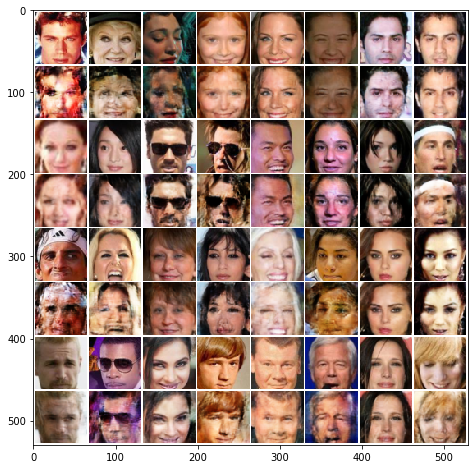

Signal error:
  MSE: 0.010675231664305024, std: 0.010149683790257949
  MAE: 0.07091965287206325, std: 0.030631606479126987
  SSIM: 0.7269903305318637, std: 0.14344731589951554
  FASI-MSE: 0.010888511886530509, std: 0.010834469252662753
  FASI-MAE: 0.0715438382401622, std: 0.032551092648563026
  COCO-MSE: 0.010039793203768022, std: 0.009504044373383902

Magnitude error:
  MSE Magnitude: 0.2932612311107514, std: 0.20227016853038285

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [131]:
print("Output under minimized magnitude distance:")
to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64),
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
plot_grid(to_plot, figsize=(8, 8), file="../out/cgan/celeba/ConvGenerator64CelebA_Drop20_3000kernSteps.png")

In [35]:
benchmark(pred=out_results, true=out_original, check=["mse", "mae", "ssim", "magn", "imcon"])

Signal error:
  MSE: 0.018382427965342594, std: 0.015348147663643267
  MAE: 0.08942446232198147, std: 0.03603295841116651
  SSIM: 0.6414480302796607, std: 0.1330312819339613

Magnitude error:
  MSE Magnitude: 4.746134181487577, std: 2.987857124315423

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01838 | 0.08942 | 0.6414 | 4.746 |


## Evaluation for different kern optimizations (4 samples)

| Nr Type | iterations | lr | MSE | MAE | SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | 
| 1 | 3000 | 1e-5 | 0.02165 | 0.1026 | 0.5816 | 17.65 |
| 2 | 3000 | 1e-5 | 0.01748 | 0.08951 | 0.6443 | 9.171 |
| 4 | 3000 | 1e-5 | 

## Evaluation for different kern optimizations (64 samples)

| Nr Type | iterations | lr | MSE | MAE | SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 3000 | 1e-5 | ?
| 2 | 3000 | 1e-5 | ?